In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS= 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\Admin\\Desktop\\skin_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4000 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['Basal Cell Carcinoma',
 'Eczema',
 'Melanoma',
 'Psoriasis',
 'Seborrheic Keratoses']

In [6]:
len(dataset)

125

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 3 4 3 0 0 1 1 1 4 0 2 2 4 4 2 2 4 0 0 3 2 0 1 3 2 2 3 0 4 3 3]


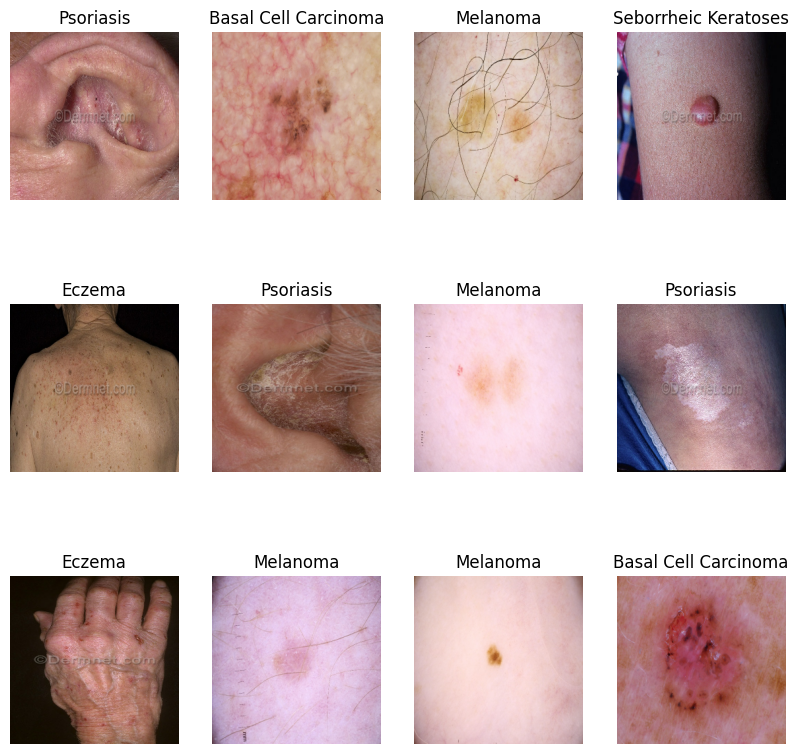

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

125

In [10]:
train_size = 0.8
len(dataset)*train_size


100.0

In [11]:
train_ds = dataset.take(100)
len(train_ds)

100

In [12]:
test_ds = dataset.skip(100)
len(test_ds)

25

In [13]:
val_size=0.1
len(dataset)*val_size

12.5

In [14]:
val_ds = test_ds.take(12)
len(val_ds)

12

In [15]:
test_ds = test_ds.skip(12)
len(test_ds)

13

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

100

In [19]:
len(val_ds)

12

In [20]:
len(test_ds)

13

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs= EPOCHS,
)

Epoch 1/50
100/100 [==============================] - 269s 2s/step - loss: 1.4430 - accuracy: 0.3322 - val_loss: 1.1304 - val_accuracy: 0.4740
Epoch 2/50
100/100 [==============================] - 234s 2s/step - loss: 1.1839 - accuracy: 0.4706 - val_loss: 1.1236 - val_accuracy: 0.5156
Epoch 3/50
100/100 [==============================] - 235s 2s/step - loss: 1.0549 - accuracy: 0.5541 - val_loss: 0.9188 - val_accuracy: 0.6042
Epoch 4/50
100/100 [==============================] - 237s 2s/step - loss: 1.0280 - accuracy: 0.5728 - val_loss: 0.8787 - val_accuracy: 0.6198
Epoch 5/50
100/100 [==============================] - 235s 2s/step - loss: 0.9481 - accuracy: 0.6066 - val_loss: 0.9307 - val_accuracy: 0.5729
Epoch 6/50
100/100 [==============================] - 237s 2s/step - loss: 0.9248 - accuracy: 0.6159 - val_loss: 1.0180 - val_accuracy: 0.5599
Epoch 7/50
100/100 [==============================] - 236s 2s/step - loss: 0.8857 - accuracy: 0.6266 - val_loss: 0.8181 - val_accuracy: 0.6406

In [29]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 7s 242ms/step - loss: 0.4939 - accuracy: 0.7885


In [30]:
scores

[0.4939287304878235, 0.7884615659713745]

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5] 

[1.4430404901504517,
 1.1839203834533691,
 1.0548502206802368,
 1.0280112028121948,
 0.9481298923492432]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [36]:
model.save('C:\\Users\\Admin\\Documents\\Model\\trained.h1')

INFO:tensorflow:Assets written to: C:\Users\Admin\Documents\Model\trained.h1\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\Documents\Model\trained.h1\assets


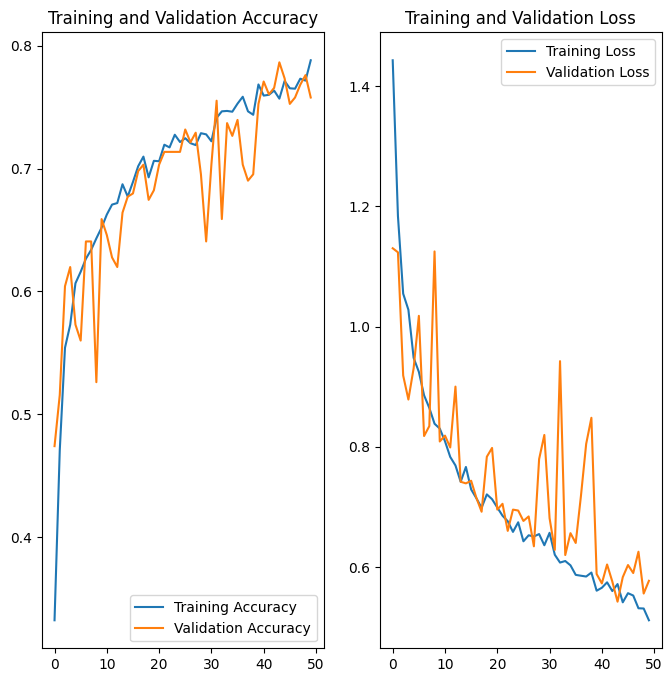

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Melanoma
1/1 [==============================] - 0s 337ms/step
predicted label: Melanoma


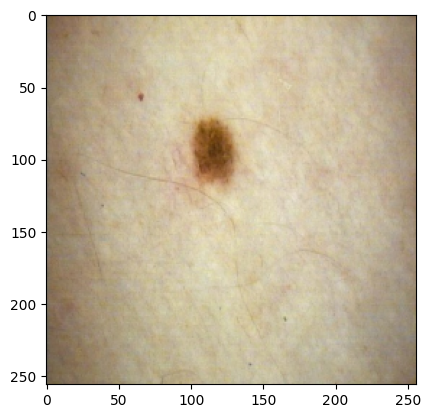

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 32
IMAGE_SIZE = 256

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\Admin\\Desktop\\skin_dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    plt.imshow(img)
    return predicted_class, confidence

Found 4000 files belonging to 5 classes.


1/1 [==============================] - 0s 142ms/step


('Melanoma', 84.52)

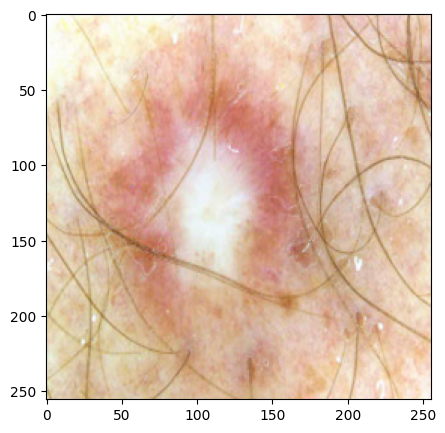

In [19]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

image_path = 'C:\\Users\\Admin\\Downloads\\dataset\\8. Seborrheic Keratoses and other Benign Tumors - 1.8k\\7_16.jpg'
image = Image.open(image_path)
img = image.resize((256, 256))
plt.figure(figsize=(5, 5))

# Convert the image to a NumPy array
image_array = np.array(img)

new_model = tf.keras.models.load_model('C:\\Users\\Admin\\Documents\\Model\\trained.h1')

predict(new_model, image_array)

1/1 [==============================] - 0s 23ms/step


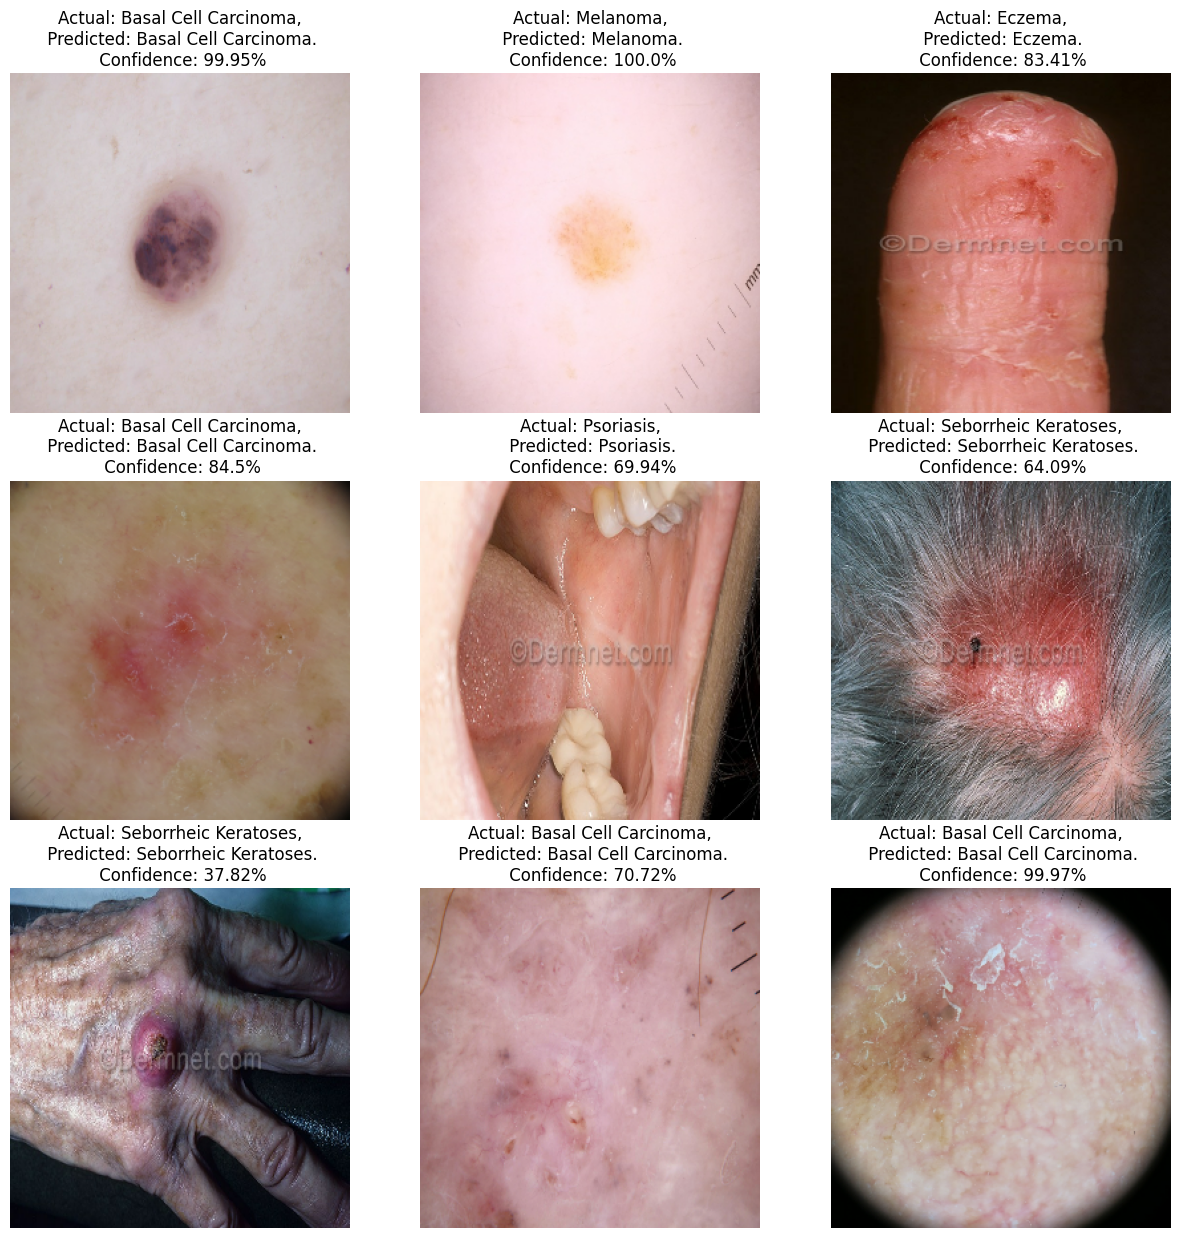

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy().astype('uint8'))
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")